# C. JS 데이터셋을 활용한 악성 코드 탐지 모델 작성

* 서준석 강사님께서 제공해주셨던 데이터셋을 편의상 JS 데이터셋이라고 부르겠습니다.
* 이 데이터셋은 아쉽게도 malware class 정보는 가지고 있지 않습니다. :(

# 1. 데이터셋 불러오기

# 1-1. JS 데이터셋 설명

JS 데이터셋은 다음 파일을 포함하고 있습니다.

* normal_pe.csv
    - 일반 파일(benign)의 PE 파일로부터 얻어진 feature
    - 총 498개 항목
    - ClaMP 데이터셋의 정보와 그 구성이 거의 같으나, 첫 두 column에 파일명 및 MD5 hash 정보가 담겨 있음
* malware_pe.csv
    - malware의 PE 파일로부터 얻어진 feature
    - 총 500개 항목
    - ClaMP 데이터셋의 정보와 그 구성이 거의 같으나, 첫 두 column에 파일명 및 MD5 hash 정보가 담겨 있음
* ngram.pe
    - 일반 파일과 malware의 code의 n-gram 통계
    - 4-gram을 사용했으며, 전체 빈도 상위 100개만 정리되어 있음
* images 폴더 내의 각종 이미지
    * malware
        - 수집된 malware의 binary로부터 얻어진 흑백 이미지
        - 이미지 파일 이름은 원본 binary의 MD5 hash
        - **_thumb** 파일은 이미지의 크기를 256*256으로 줄인 것(단, 원래 이미지의 크기가 이것보다 작은 경우는 원본과 같음)
    * normal
        - 수집된 일반 파일(benign)의 binary로부터 얻어진 흑백 이미지
        - 이미지 파일 이름은 원본 binary의 MD5 hash
        - **_thumb** 파일은 이미지의 크기를 256*256으로 줄인 것(단, 원래 이미지의 크기가 이것보다 작은 경우는 원본과 같음)

각 자료의 모든 항목은 MD5 hash로 연결할 수 있으며, 일부 데이터는 손실된 값을 포함합니다.

## 1-2. PE 파일 feature 읽어오기

우선 PE 파일로부터 얻은 feature들(**normal_pe.csv**, **malware_pe.csv**)을 읽어와서 하나의 학습 자료로 합칩시다.

처리한 뒤 **filename**과 **packer_type** 컬럼은 날려버립니다. **MD5** 컬럼은 각 자료의 구분자(identifier) 역할을 하므로 지금은 남겨둡니다. 그러면,

* identifier : 0번 column (0-based)
* feature : 1~68번 column (0-based)
* 정답(malware 여부) : 69번 column (0-based)

이 됩니다.

In [15]:
import pandas as pd
import numpy as np

normal_pe = pd.read_csv('JS dataset/normal_pe.csv') 
print("Total {} entries in normal_pe.csv".format(len(normal_pe)))
normal_pe = normal_pe.dropna()
print("Total {} valid entries in normal_pe.csv".format(len(normal_pe)))

malware_pe = pd.read_csv('JS dataset/malware_pe.csv') 
print("Total {} entries in malware_pe.csv".format(len(malware_pe)))
malware_pe = malware_pe.dropna()
print("Total {} valid entries in malware_pe.csv".format(len(malware_pe)))

all_pe = pd.concat([normal_pe, malware_pe]).drop(['filename', 'packer_type'], axis = 1)
print("Total {} entries".format(len(all_pe)))

# 혹시 모르니까 저장해둡니다.
all_pe.to_csv('all_pe.csv', index = False)
all_pe.info()

Total 498 entries in normal_pe.csv
Total 467 valid entries in normal_pe.csv
Total 500 entries in malware_pe.csv
Total 470 valid entries in malware_pe.csv
Total 937 entries
<class 'pandas.core.frame.DataFrame'>
Int64Index: 937 entries, 0 to 499
Data columns (total 70 columns):
MD5                            937 non-null object
e_cblp                         937 non-null int64
e_cp                           937 non-null int64
e_cparhdr                      937 non-null int64
e_maxalloc                     937 non-null int64
e_sp                           937 non-null int64
e_lfanew                       937 non-null int64
NumberOfSections               937 non-null int64
CreationYear                   937 non-null int64
FH_char0                       937 non-null int64
FH_char1                       937 non-null int64
FH_char2                       937 non-null int64
FH_char3                       937 non-null int64
FH_char4                       937 non-null int64
FH_char5              

## 1-3. N-gram feature 읽어오기

이것도 읽어온 뒤 **filename** 컬럼은 날립니다.

* identifier : 0번째 column (0-based)
* N-gram 개수 : 1~100번째 column (0-based)
* 정답(malware 여부) : 101번째 column (0-based)

In [17]:
ngram = pd.read_csv('JS dataset/ngram.csv').dropna()
ngram = ngram.drop(['filename'], axis = 1)
ngram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Columns: 102 entries, MD5 to class
dtypes: int64(101), object(1)
memory usage: 803.1+ KB


## 1-4. binary의 이미지 읽어오기

이 자료는 설명할 것도 있고 읽어오기도 좀 번거롭습니다. 차근차근 해 봅시다.

### 1-4-1. binary로부터 이미지를 만드는 방법

아래 코드는 **JS dataset/samples/peid.exe** 파일을 불러와서 이미지로 저장하는 예제입니다.

In [51]:
import os, array, sys
import matplotlib.pyplot as plt
from PIL import Image

filename = 'JS dataset/samples/peid.exe'
thumbnail_size = 256, 256
full_png = "peid_image.png"
thumbnail_png = "peid_image_thumb.png"

with open(filename,'rb') as f:
    file_length = os.path.getsize(filename) 

    #width = \sqrt{length}
    width = int(file_length**0.5)
    height = file_length // width
    rem = file_length % width 

    binary_data = array.array("B") 
    binary_data.fromfile(f, file_length - rem) 

binary_data = np.reshape(binary_data, (height, width)) 
binary_data = np.uint8(binary_data)

image = Image.frombytes(mode = 'L', size = (height, width), data = binary_data)
image.save(full_png, "PNG")

thumbnail = Image.open(full_png)
thumbnail.thumbnail(thumbnail_size, Image.ANTIALIAS) 
thumbnail.save(thumbnail_png, "PNG")

### 1-4-2. thumbnail들만 읽어오기

아래 코드를 이용해서 위 코드처럼 만들어진 이미지들을 읽어옵니다. 이 때 주의할 점은 thumbnail의 기본 크기는 256*256이지만 일부 이미의 크기는 이것보다 작다는 점입니다.

In [95]:
import os, sys
from PIL import Image

def get_bin_images(bin_images, target_labels, label, path):
    # path에 있는 파일 중에서 끝이 _thumb.png 로 끝나는 것들의 목록을 얻습니다.
    filelist = [filename for filename in os.listdir(path) if filename.endswith('_thumb.png')]
    for file in filelist:
        filename = os.path.join(path, file)
        im = Image.open(filename).convert("L")
        bin_data = np.array(im.resize((256, 256), resample = Image.BILINEAR))
        bin_data = bin_data.reshape(256, 256, 1)
        bin_images.append(bin_data)
        target_labels.append(label)

normal_path = 'JS dataset/images/normal'
malware_path = 'JS dataset/images/malware'

bin_images = []
target_labels = []
get_bin_images(bin_images, target_labels, 0, normal_path)
get_bin_images(bin_images, target_labels, 1, malware_path)
bin_images = np.array(bin_images)
target_labels = np.array(target_labels)
print(bin_images.shape)

(998, 256, 256, 1)


## 1-5. 자료 가공 함수 만들기

여태 써 온 것과 같습니다. :)

In [74]:
def generate_training_and_test_data(original_data,
                                    idx_features,
                                    idx_class,
                                    cv_ratio = 0.8,
                                    normalize = True,
                                    convert_categorical_to_ohv = True):
    x_data = np.array(original_data[:, idx_features], dtype = np.float32)
    y_data = np.array(original_data[:, idx_class], dtype = np.int32)

    num_features = len(idx_features)
    num_classes  = np.max(y_data) + 1

    rand_idx = np.arange(0, len(x_data))
    np.random.shuffle(rand_idx)

    len_train = int(len(rand_idx) * cv_ratio)
    len_test = len(rand_idx) - len_train

    x_train = x_data[rand_idx[:len_train]]
    y_train = y_data[rand_idx[:len_train]]
    if convert_categorical_to_ohv:
        y_train = keras.utils.to_categorical(y_train, num_classes)

    x_test = x_data[rand_idx[len_train:]]
    y_test = y_data[rand_idx[len_train:]]
    if convert_categorical_to_ohv:
        y_test = keras.utils.to_categorical(y_test, num_classes)

    #이제 정규화를 좀 합시다.
    if normalize:
        x_max = np.max(x_data, axis = 0)
        x_min = np.min(x_data, axis = 0)
        x_train = (x_train - x_min) / (x_max - x_min + 1e-7)
        x_test  = (x_test  - x_min) / (x_max - x_min + 1e-7)

    print("shape of x_train and y_train : ", x_train.shape, y_train.shape)
    print("shape of x_test  and y_test  : ", x_test.shape, y_test.shape)
    
    return x_train, y_train, x_test, y_test, num_features, num_classes

# 2. 보조함수 작성

scikit-learn은 기계학습 모델 평가를 위한 다양한 함수를 제공합니다. 이 함수들을 이용해서, 학습 결과를 시각화하는 보조함수들을 만듭니다.

In [75]:
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def do_confusion(test, pred):
    cnf_matrix = confusion_matrix(test, pred)
    plot_confusion_matrix(cnf_matrix, classes=['benign', 'malware'])
    
    return accuracy_score(test, pred)

def do_f1(test, pred):
    return f1_score(test, pred)

# 3. PE 정보를 활용한, 기계학습 / 신경망 모델을 이용한 악성 코드 판정 모델

앞선 노트북에서 했던 내용 반복입니다.

In [76]:
# decision tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

def do_decision(x, y, test):
    clf = tree.DecisionTreeClassifier()
    clf.fit(x, y)
    y_pred = clf.predict(test)
    
    return y_pred


def do_randomforest(x, y, test, returnModel = False):
    clf = RandomForestClassifier(n_estimators=1000, max_depth=200,random_state=0)
    clf.fit(x, y)  
    print(clf.feature_importances_)
    y_pred = clf.predict(test)
    
    if returnModel:
        return y_pred, clf
    else:
        return y_pred

## 3-1. Decision Tree를 이용한 모델

shape of x_train and y_train :  (749, 68) (749,)
shape of x_test  and y_test  :  (188, 68) (188,)
Confusion matrix, without normalization
[[77  8]
 [ 5 98]]
DT accuracy:  0.9308510638297872
f1 score:  0.9377990430622011


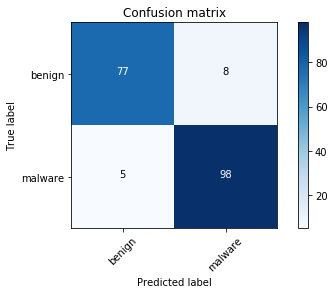

In [77]:
# Diffusion matrix를 그리기 위해서는 y_train, y_test가 multiclass여야합니다. one-hot vector는 multilabel로 취급됩니다.
# 따라서 convert_categorical_to_ohv = False 로 합니다.
x_train, y_train, x_test, y_test, num_features, num_classes = generate_training_and_test_data(all_pe.values,
                                                                        np.arange(1, 69), 69,
                                                                        convert_categorical_to_ohv=False)

y_pred = do_decision(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 3-2. RandomForest를 이용한 모델

이번에는 RandomForest를 이용한 모델입니다.

중간 결과로 출력되는 68개 항목을 가진 벡터(행렬)은, 68개의 feature가 결과에 얼마나 영향을 끼치는지를 계산한 값입니다. 이 값이 클 수록 결과에 미치는 영향이 큽니다. 즉, 더 **중요한** feature입니다. 이것에 대한 분석은 나중에...

[1.71422275e-03 2.52267440e-03 1.77815769e-03 5.89265620e-04
 2.06188502e-03 1.70733569e-02 7.28706912e-03 9.14035238e-03
 6.66994412e-02 0.00000000e+00 3.88954469e-02 3.41135979e-02
 0.00000000e+00 7.45245575e-03 8.39656310e-04 8.59951135e-04
 1.20698986e-03 3.04243765e-03 3.69675485e-03 0.00000000e+00
 6.65473793e-04 0.00000000e+00 1.42204514e-03 5.00678154e-02
 1.78684307e-02 1.51656079e-02 3.54536174e-02 1.69368031e-02
 1.75193312e-02 5.51180384e-03 1.27010114e-02 6.73965305e-03
 0.00000000e+00 0.00000000e+00 2.39429642e-02 2.34849684e-03
 7.09982780e-03 1.25186862e-03 4.96278112e-02 1.63213799e-03
 1.42173014e-05 0.00000000e+00 1.96254910e-02 5.73614869e-02
 6.31236265e-02 1.40997270e-05 6.27564853e-02 0.00000000e+00
 4.48145020e-03 0.00000000e+00 0.00000000e+00 3.37089790e-03
 4.83413261e-03 0.00000000e+00 6.66280194e-05 2.05770990e-02
 1.18141896e-02 2.18178253e-03 1.16102519e-03 2.94871671e-05
 6.98657572e-03 1.15097027e-02 2.41353910e-03 3.24170400e-02
 1.35924732e-02 3.915454

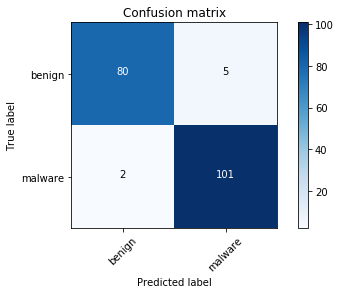

In [78]:
y_pred = do_randomforest(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 3-3. DNN을 이용한 모델

신경망을 이용한 모델을 만들어서 성능을 비교해 보겠습니다.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 68)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      1380        
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       11          
________________________________________________________________________________
activation_2 (Activation)           (None, 1)                       0           
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________

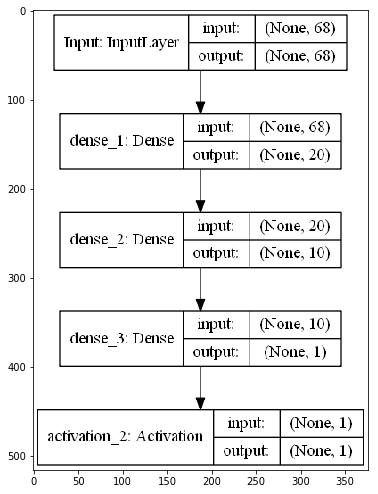

In [82]:
import keras as keras
from keras.utils import plot_model

#간단한 모델
num_classes = 1

inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(20, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(10, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(num_classes, name = 'dense_3')(dense2)
out = keras.layers.Activation('tanh')(dense3)

first_model = keras.Model(inp, out, name = 'first_dnn_JS_PE')
first_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
first_model.summary(80)
plot_model(first_model, to_file='first_dnn_JS_PE.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('first_dnn_JS_PE.png'))

In [83]:
first_model.fit(x = x_train, y = y_train,
                validation_data = [x_test, y_test],
                initial_epoch = 0,
                epochs = 100)

Train on 749 samples, validate on 188 samples
Epoch 1/100
749/749 [==============================] - 2s 2ms/step - loss: 7.8801 - acc: 0.3792 - val_loss: 8.8307 - val_acc: 0.3457
Epoch 2/100
749/749 [==============================] - 0s 120us/step - loss: 7.8610 - acc: 0.4299 - val_loss: 8.3215 - val_acc: 0.4202
Epoch 3/100
749/749 [==============================] - 0s 119us/step - loss: 4.2448 - acc: 0.5527 - val_loss: 1.1978 - val_acc: 0.7128
Epoch 4/100
749/749 [==============================] - 0s 122us/step - loss: 0.4154 - acc: 0.8398 - val_loss: 0.4003 - val_acc: 0.7926
Epoch 5/100
749/749 [==============================] - 0s 118us/step - loss: 0.2752 - acc: 0.8758 - val_loss: 0.3459 - val_acc: 0.7872
Epoch 6/100
749/749 [==============================] - 0s 119us/step - loss: 0.2438 - acc: 0.8879 - val_loss: 0.3217 - val_acc: 0.8617
Epoch 7/100
749/749 [==============================] - 0s 120us/step - loss: 0.2324 - acc: 0.8985 - val_loss: 0.3103 - val_acc: 0.8511
Epoch 8/100

Epoch 61/100
749/749 [==============================] - 0s 118us/step - loss: 0.1145 - acc: 0.6809 - val_loss: 0.3463 - val_acc: 0.5798
Epoch 62/100
749/749 [==============================] - 0s 117us/step - loss: 0.1068 - acc: 0.6649 - val_loss: 0.3334 - val_acc: 0.6755
Epoch 63/100
749/749 [==============================] - 0s 118us/step - loss: 0.1061 - acc: 0.6676 - val_loss: 0.3484 - val_acc: 0.5798
Epoch 64/100
749/749 [==============================] - 0s 116us/step - loss: 0.1062 - acc: 0.6569 - val_loss: 0.3547 - val_acc: 0.5851
Epoch 65/100
749/749 [==============================] - 0s 118us/step - loss: 0.1035 - acc: 0.6489 - val_loss: 0.3315 - val_acc: 0.6649
Epoch 66/100
749/749 [==============================] - 0s 116us/step - loss: 0.1047 - acc: 0.6702 - val_loss: 0.3349 - val_acc: 0.6596
Epoch 67/100
749/749 [==============================] - 0s 118us/step - loss: 0.1079 - acc: 0.6409 - val_loss: 0.3310 - val_acc: 0.6596
Epoch 68/100
749/749 [==========================

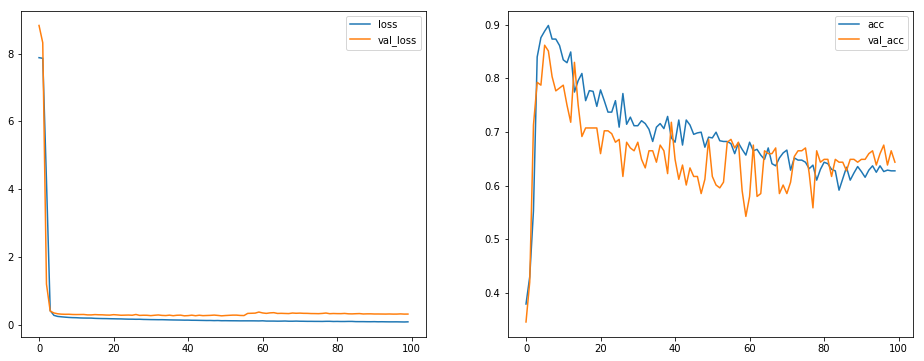

Confusion matrix, without normalization
[[75 10]
 [ 4 99]]
DT accuracy:  0.925531914893617
f1 score:  0.9339622641509433


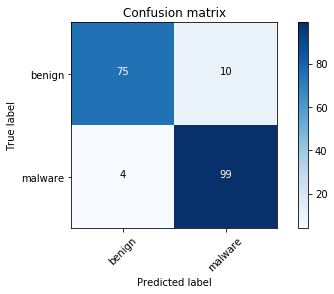

In [84]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(first_model.history.history['loss'])
ax.plot(first_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(first_model.history.history['acc'])
ax.plot(first_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

y_pred = first_model.predict(x_test) >= 0.5
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

# 4. N-gram 정보를 활용한, 기계학습 / 신경망 모델을 이용한 악성 코드 판정 모델

비슷한 내용인데, N-gram 정보를 가지고 해봅시다. 좀 지겨울 수도 있겠습니다. :(

## 4-1. Decision Tree를 이용한 모델

shape of x_train and y_train :  (798, 100) (798,)
shape of x_test  and y_test  :  (200, 100) (200,)
Confusion matrix, without normalization
[[94  3]
 [39 64]]
DT accuracy:  0.79
f1 score:  0.7529411764705882


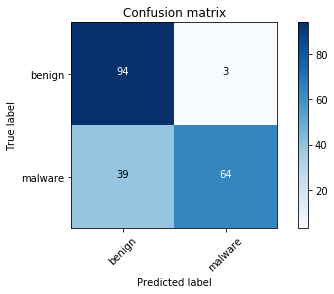

In [85]:
# Diffusion matrix를 그리기 위해서는 y_train, y_test가 multiclass여야합니다. one-hot vector는 multilabel로 취급됩니다.
# 따라서 convert_categorical_to_ohv = False 로 합니다.
x_train, y_train, x_test, y_test, num_features, num_classes = generate_training_and_test_data(ngram.values,
                                                                        np.arange(1, 101), 101,
                                                                        convert_categorical_to_ohv=False)

y_pred = do_decision(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 4-2. RandomForest를 이용한 모델

이번에는 RandomForest를 이용한 모델입니다.

중간 결과로 출력되는 68개 항목을 가진 벡터(행렬)은, 68개의 feature가 결과에 얼마나 영향을 끼치는지를 계산한 값입니다. 이 값이 클 수록 결과에 미치는 영향이 큽니다. 즉, 더 **중요한** feature입니다. 이것에 대한 분석은 나중에...

[0.04874968 0.01054125 0.14495206 0.02524652 0.03009353 0.03177105
 0.00433358 0.00815484 0.04590645 0.03956025 0.01371615 0.00151973
 0.030545   0.00807528 0.00667047 0.00603903 0.00194016 0.00460512
 0.00736047 0.00543374 0.01704026 0.00566966 0.01061396 0.01211595
 0.00281937 0.00329339 0.00032107 0.01286173 0.01354524 0.00587164
 0.01323248 0.00312191 0.00220326 0.00235    0.00698933 0.01414928
 0.00355638 0.00540297 0.00913244 0.00437143 0.00254329 0.00795091
 0.00863654 0.00845316 0.01184154 0.01233737 0.00362077 0.0034534
 0.00584941 0.00047965 0.0056266  0.00272615 0.03973705 0.00496307
 0.00521172 0.00298083 0.00055813 0.00254206 0.00289203 0.00309999
 0.00301122 0.00270272 0.01076856 0.00416641 0.00401294 0.00675101
 0.00717946 0.00294537 0.00370196 0.00157511 0.00694881 0.00831833
 0.00995978 0.00895456 0.005836   0.04095279 0.00113004 0.00329809
 0.00102838 0.00262433 0.0049126  0.00258076 0.00305016 0.00288395
 0.00362188 0.01726058 0.00186849 0.02181626 0.00459398 0.00649

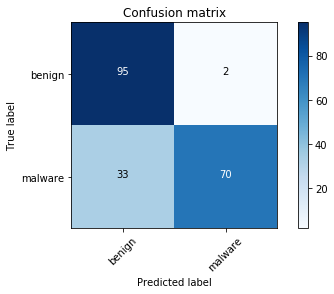

In [86]:
y_pred = do_randomforest(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 4-3. DNN을 이용한 모델

신경망을 이용한 모델을 만들어서 성능을 비교해 보겠습니다.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 100)                     0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      2020        
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       11          
________________________________________________________________________________
activation_4 (Activation)           (None, 1)                       0           
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________

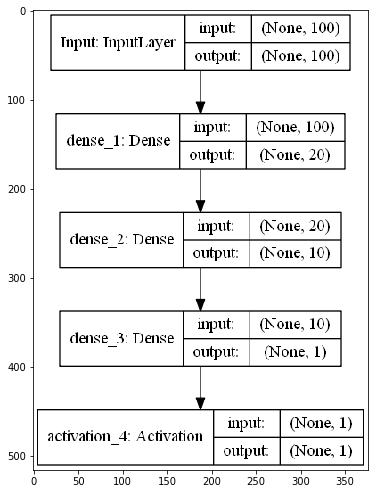

In [88]:
import keras as keras
from keras.utils import plot_model

#간단한 모델
num_classes = 1

inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(20, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(10, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(num_classes, name = 'dense_3')(dense2)
out = keras.layers.Activation('tanh')(dense3)

second_model = keras.Model(inp, out, name = 'first_dnn_JS_NGRAM')
second_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
second_model.summary(80)
plot_model(second_model, to_file='first_dnn_JS_NGRAM.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('first_dnn_JS_NGRAM.png'))

In [89]:
second_model.fit(x = x_train, y = y_train,
                validation_data = [x_test, y_test],
                initial_epoch = 0,
                epochs = 100)

Train on 798 samples, validate on 200 samples
Epoch 1/100
798/798 [==============================] - 0s 513us/step - loss: 1.4335 - acc: 0.4912 - val_loss: 1.0872 - val_acc: 0.4950
Epoch 2/100
798/798 [==============================] - 0s 125us/step - loss: 0.8844 - acc: 0.6115 - val_loss: 0.8999 - val_acc: 0.6200
Epoch 3/100
798/798 [==============================] - 0s 137us/step - loss: 0.7704 - acc: 0.6642 - val_loss: 0.8041 - val_acc: 0.6200
Epoch 4/100
798/798 [==============================] - 0s 145us/step - loss: 0.7026 - acc: 0.6679 - val_loss: 0.7367 - val_acc: 0.6200
Epoch 5/100
798/798 [==============================] - 0s 130us/step - loss: 0.6525 - acc: 0.6704 - val_loss: 0.6846 - val_acc: 0.6200
Epoch 6/100
798/798 [==============================] - 0s 125us/step - loss: 0.6115 - acc: 0.6742 - val_loss: 0.6439 - val_acc: 0.6250
Epoch 7/100
798/798 [==============================] - 0s 129us/step - loss: 0.5816 - acc: 0.6892 - val_loss: 0.6066 - val_acc: 0.6300
Epoch 8/1

Epoch 61/100
798/798 [==============================] - 0s 117us/step - loss: 0.4013 - acc: 0.7820 - val_loss: 0.4451 - val_acc: 0.7500
Epoch 62/100
798/798 [==============================] - 0s 118us/step - loss: 0.4005 - acc: 0.7782 - val_loss: 0.4446 - val_acc: 0.7600
Epoch 63/100
798/798 [==============================] - 0s 119us/step - loss: 0.3986 - acc: 0.7832 - val_loss: 0.4415 - val_acc: 0.7600
Epoch 64/100
798/798 [==============================] - 0s 121us/step - loss: 0.3998 - acc: 0.7857 - val_loss: 0.4549 - val_acc: 0.7550
Epoch 65/100
798/798 [==============================] - 0s 144us/step - loss: 0.3985 - acc: 0.7757 - val_loss: 0.4455 - val_acc: 0.7500
Epoch 66/100
798/798 [==============================] - 0s 129us/step - loss: 0.3946 - acc: 0.7794 - val_loss: 0.4384 - val_acc: 0.7500
Epoch 67/100
798/798 [==============================] - 0s 129us/step - loss: 0.3931 - acc: 0.7870 - val_loss: 0.4359 - val_acc: 0.7600
Epoch 68/100
798/798 [==========================

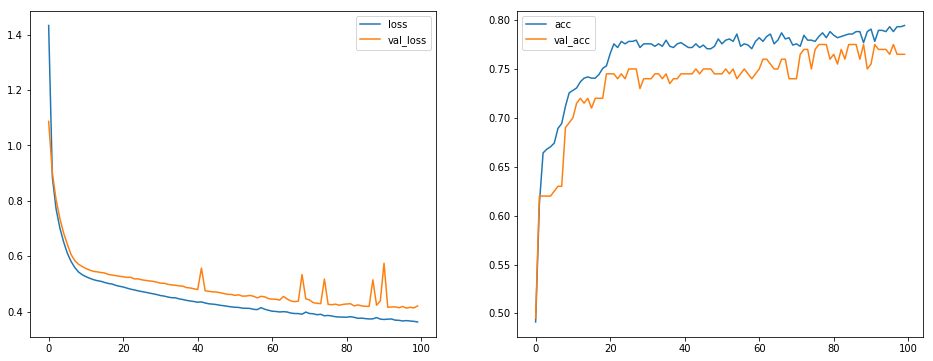

Confusion matrix, without normalization
[[97  0]
 [43 60]]
DT accuracy:  0.785
f1 score:  0.7361963190184049


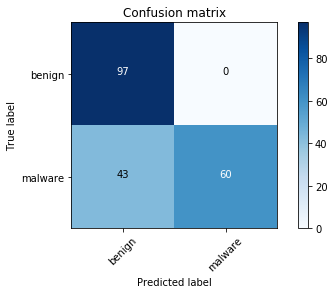

In [90]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(second_model.history.history['loss'])
ax.plot(second_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(second_model.history.history['acc'])
ax.plot(second_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

y_pred = second_model.predict(x_test) >= 0.5
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

N-gram 정보만 이용해서는, 최소한 현재 세팅 - 4-gram 빈도 상위 10000개 - 으로는 악성 코드 판별에 어려움이 있는 것처럼 보입니다.

# 5. binary 이미지를 이용한 악성 코드 판별

이제 이미지를 이용하여 악성 코드를 판별하는 모델을 만듭시다.

In [99]:
def generate_training_and_test_data_2(x_data,
                                      y_data,
                                      cv_ratio = 0.8,
                                      normalize = True,
                                      convert_categorical_to_ohv = True):

    num_classes = np.max(y_data) + 1
    rand_idx = np.arange(0, len(x_data))
    np.random.shuffle(rand_idx)

    len_train = int(len(rand_idx) * cv_ratio)
    len_test = len(rand_idx) - len_train

    x_train = x_data[rand_idx[:len_train]]
    y_train = y_data[rand_idx[:len_train]]
    if convert_categorical_to_ohv:
        y_train = keras.utils.to_categorical(y_train, num_classes)

    x_test = x_data[rand_idx[len_train:]]
    y_test = y_data[rand_idx[len_train:]]
    if convert_categorical_to_ohv:
        y_test = keras.utils.to_categorical(y_test, num_classes)

    #이제 정규화를 좀 합시다.
    if normalize:
        x_max = np.max(x_data, axis = 0)
        x_min = np.min(x_data, axis = 0)
        x_train = (x_train - x_min) / (x_max - x_min + 1e-7)
        x_test  = (x_test  - x_min) / (x_max - x_min + 1e-7)

    print("shape of x_train and y_train : ", x_train.shape, y_train.shape)
    print("shape of x_test  and y_test  : ", x_test.shape, y_test.shape)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_training_and_test_data_2(bin_images, target_labels)

shape of x_train and y_train :  (798, 256, 256, 1) (798, 2)
shape of x_test  and y_test  :  (200, 256, 256, 1) (200, 2)


________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_14 (InputLayer)               (None, 256, 256, 1)             0           
________________________________________________________________________________
conv1_6_filters (Conv2D)            (None, 256, 256, 3)             195         
________________________________________________________________________________
maxpooling1 (MaxPooling2D)          (None, 32, 32, 3)               0           
________________________________________________________________________________
conv2_12_filters (Conv2D)           (None, 32, 32, 6)               1158        
________________________________________________________________________________
maxpooling2 (MaxPooling2D)          (None, 4, 4, 6)                 0           
________________________________________________________________________________
flatten (Flatten)           

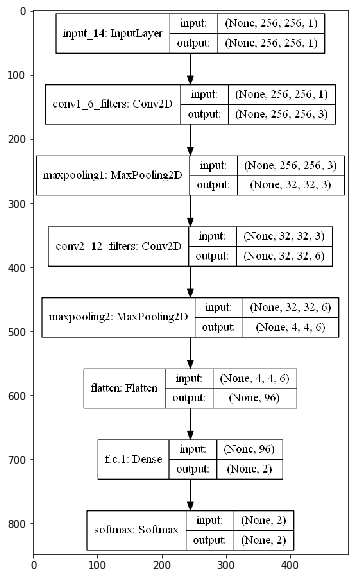

In [117]:
inp = keras.layers.Input(shape = (256, 256, 1))

conv1 = keras.layers.Conv2D(filters = 3, kernel_size = (8, 8), padding = 'same', name = 'conv1_6_filters')(inp)
conv1 = keras.layers.pooling.MaxPooling2D(pool_size = (8, 8), padding = 'valid', name = 'maxpooling1', strides = None)(conv1)

conv2 = keras.layers.Conv2D(filters = 6, kernel_size = (8, 8), padding = 'same', name = 'conv2_12_filters')(conv1)
conv2 = keras.layers.pooling.MaxPooling2D(pool_size = (8, 8), padding = 'valid', name = 'maxpooling2', strides = None)(conv2)

fc = keras.layers.Flatten(name = 'flatten')(conv2)
#fc = keras.layers.Dense(30, activation = 'tanh')(fc)
fc = keras.layers.Dense(2, name = 'f.c.1')(fc)

out = keras.layers.Softmax(2, name = 'softmax')(fc)

cnn_model = keras.Model(inp, out, name = 'cnn_JS_image')
cnn_model.summary(80)
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

plot_model(cnn_model, to_file='cnn_JS_image.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('cnn_JS_image.png'))

In [118]:
cnn_model.fit(x = x_train, y = y_train,
                validation_data = [x_test, y_test],
                initial_epoch = 0,
                epochs = 30)

Train on 798 samples, validate on 200 samples
Epoch 1/30
798/798 [==============================] - 2s 2ms/step - loss: 0.6104 - acc: 0.6466 - val_loss: 0.5551 - val_acc: 0.7650
Epoch 2/30
798/798 [==============================] - 1s 1ms/step - loss: 0.5154 - acc: 0.7882 - val_loss: 0.5156 - val_acc: 0.8000
Epoch 3/30
798/798 [==============================] - 1s 1ms/step - loss: 0.4821 - acc: 0.8020 - val_loss: 0.4882 - val_acc: 0.8300
Epoch 4/30
798/798 [==============================] - 1s 1ms/step - loss: 0.4577 - acc: 0.8145 - val_loss: 0.4620 - val_acc: 0.8200
Epoch 5/30
798/798 [==============================] - 1s 1ms/step - loss: 0.4234 - acc: 0.8283 - val_loss: 0.4358 - val_acc: 0.8200
Epoch 6/30
798/798 [==============================] - 1s 1ms/step - loss: 0.4016 - acc: 0.8521 - val_loss: 0.4145 - val_acc: 0.8500
Epoch 7/30
798/798 [==============================] - 1s 1ms/step - loss: 0.3720 - acc: 0.8684 - val_loss: 0.3957 - val_acc: 0.8500
Epoch 8/30
798/798 [==========

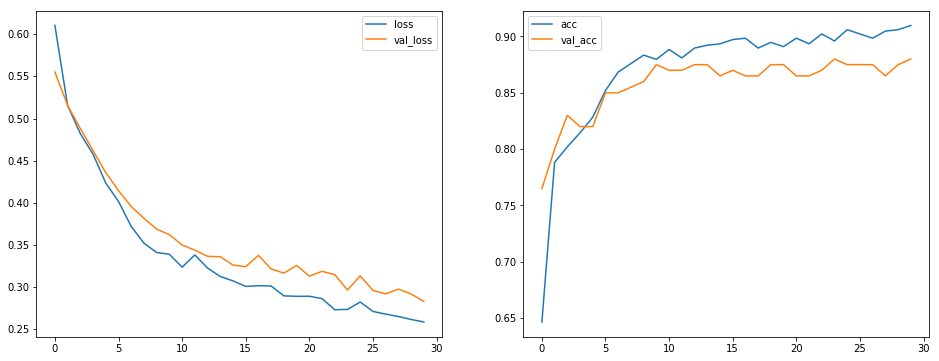

Confusion matrix, without normalization
[[99 11]
 [13 77]]
DT accuracy:  0.88
f1 score:  0.8651685393258427


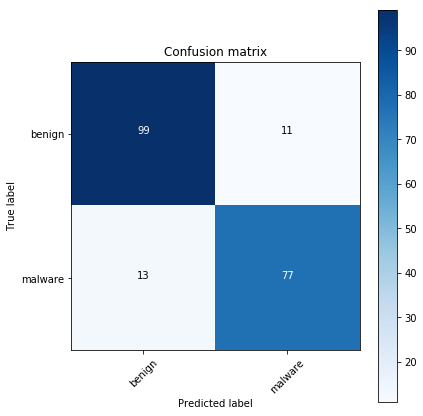

In [127]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(cnn_model.history.history['loss'])
ax.plot(cnn_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(cnn_model.history.history['acc'])
ax.plot(cnn_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

y_pred = np.argmax(cnn_model.predict(x_test), axis = -1)
_y_test = np.argmax(y_test, axis = -1)
plt.figure(figsize = (6, 6))
print('DT accuracy: ', do_confusion(_y_test, y_pred))
print("f1 score: ", do_f1(_y_test, y_pred))

생각보다 성능이 나옵니다. 물론 학습 및 평가 자료의 수가 너무 적다는 치명적인 문제점은 있습니다...